In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
import sys
path = 'Models/keras_Realtime_Multi-Person_Pose_Estimation'
# Add the path to the library to sys.path
sys.path.append(path)
from processing import extract_parts, draw, extract_parts2

from config_reader import config_reader
from model.cmu_model import get_testing_model
import util

In [3]:
def mppe(image, params, model, model_params):    
    input_image = image
    
    body_parts, all_peaks, subset, candidate = extract_parts(input_image, params, model_mppe, model_params)
    canvas = draw(input_image, all_peaks, subset, candidate)

    return canvas

In [4]:
model_mppe = get_testing_model()
model_mppe.load_weights(f'{path}/model/keras/model.h5')
# load config
params, model_params = config_reader(f'{path}/config')

dim_reduce = 0.5

In [24]:
def tensor_toint(tensors):
    tensor_ints = []
    for tensor in tensors:
        tensor_ints.append(int(tensor))
    return tensor_ints

In [23]:
def midpoint_single(point1, point2):
    if point1 and point2:
        x1, y1 = point1
        x2, y2 = point2
        # Both variables are present, calculate midpoint
        midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)
        return midpoint
    elif point1:
        # Only var1 is present
        return point1
    elif point2:
        # Only var2 is present
        return point2
    else:
        # Both variables are None
        return None

In [22]:
def visualise(cropped_frame, bl, br):
   # plot people on graph
            body_parts, all_peaks, subset, candidate = extract_parts(cropped_frame, params, model_mppe, model_params)

            positions = []
            body_parts_list = []
            for i, key in zip(range(18), body_parts.keys()):
                # list to hold limbs already plotted
                plotted_list = []
                if len(all_peaks[i])>1:
                    sorted_peaks = sorted(all_peaks[i], key=lambda x: x[2])
                elif len(all_peaks[i]) == 0:
                    continue
                else:
                    sorted_peaks = all_peaks[i]
                a = sorted_peaks[0][0]
                b = sorted_peaks[0][1]
                adj_a, adj_b = bl+a, br+b
                if (adj_a, adj_b) not in plotted_list:
                    plotted_list.append((adj_a,adj_b))
                else:
                    a = sorted_peaks[1][0]
                    b = sorted_peaks[1][1]
                    adj_a, adj_b = bl+a, br+b
                
                if body_parts[key] != (None, None):
                     body_parts_list.append(key)
                positions.append([adj_a,adj_b])

            return np.array(positions), body_parts_list

In [21]:
def find_dominant_colour(img):
    pixels = np.float32(img.reshape(-1, 3))
    n_colorus = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    
    _, labels, palette = cv2.kmeans(pixels, n_colorus, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    
    dominant_colour = palette[np.argmax(counts)]

    return dominant_colour

In [20]:
def find_closest_match(targets, other, other_player):
    prev_difference = None
    for i, target in enumerate(targets):
        
        difference = other-target
        mean_difference = np.mean(difference)
        print(prev_difference, mean_difference)
        if not prev_difference:
            prev_difference = mean_difference
        else:
            if abs(prev_difference) <= abs(mean_difference):
                return i-1
            else:
                return i
        

In [43]:
feetpositions = []
def plot(cap, yolo_model):
    body_parts_list = ['nose', 'neck', 'right_shoulder', ' right_elbow', 'right_wrist', 'left_shoulder', 'left_elbow', 'left_wrist', 'right_hip', 'right_knee', 'right_ankle', 'left_hip', 'left_knee', 'left_ankle', 'right_eye', 'left_eye', 'right_ear', 'left_ear']
    body_part_dict = {}
    for part in body_parts_list:
        body_part_dict[part] = None

    player_colours = []
        
    while cap.isOpened():
        feetpositions.append([[None,None],[None, None]])
        # Read a frame from the video
        success, frame = cap.read()
        
        if success:
            # Run YOLOv8 tracking on the frame
            results = yolo_model(frame, conf=0.2, max_det=2, classes=0)

            # Get the boxes
            boxes = results[0].boxes.xyxy.cpu()
            
            for j, box in enumerate(boxes):
                bl, br, tl, tr = tensor_toint(box)
                cropped_frame = frame[br:tr, bl:tl]

                # dominant_colour = find_dominant_colour(cropped_frame)
                # if len(player_colours) < 2:
                #     player_colours.append(dominant_colour)
                #     player = j
                # else:
                #     player = find_closest_match(player_colours, dominant_colour)
                #     print(player)
                
                #plt.imshow(frame)
                h,w,_ = cropped_frame.shape

                # if player == 0:
                #     colour = 'red'
                # else:
                #     colour = 'blue'
                

                positions, body_parts = visualise(cropped_frame, bl, tr-h)
                #positions[:,1] *= -1
                plt.scatter(positions[:, 0], positions[:, 1])#, c=colour)

                #Add labels to points
                for i, label in enumerate(body_parts):
                    #plt.text(positions[i, 0], positions[i, 1], label+str(j), fontsize=5, ha='left', va='bottom')
                    body_part_dict[label] = positions[i, 0], positions[i, 1]
                
                right_foot_coords = body_part_dict['right_ankle']
                left_foot_coords = body_part_dict['left_ankle']

                feet_pos = midpoint_single(right_foot_coords, left_foot_coords)

                if feet_pos:
                    feetpositions[-1][j] = [feet_pos[0], feet_pos[1]]
                    plt.scatter(*feet_pos, s=100)
    
            plt.show()
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Break the loop if the end of the video is reached
            break

In [17]:
def see(cap, yolo_model, window_name):
    while cap.isOpened():
    # Read a frame from the video
        success, frame = cap.read()
    
        if success:
            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = yolo_model(frame, conf=0.2, max_det=2, classes=0)
            #frame = results[0].plot()
            # print(results[0].keypoints)
            # Get the boxes
            boxes = results[0].boxes.xyxy.cpu()
    
            for i, box in enumerate(boxes):
                print(i)
                bl, br, tl, tr = tensor_toint(box)
                cropped_frame = frame[br:tr, bl:tl]

                canvas = mppe(cropped_frame, params, model_mppe, model_params)
                result = cv2.addWeighted(cropped_frame, 1, canvas, 1, 0)
                frame[br:tr, bl:tl] = result
    
            cv2.imshow(window_name, frame)
            key = cv2.waitKey(0)
     
            # Break the loop if 'q' is pressed
            if key & 0xFF == ord("q"):
                break
            
        else:
            # Break the loop if the end of the video is reached
            break

   

In [36]:
def main(watch=False):
    # Load the YOLOv8 model
    yolo_model = YOLO('yolov8n.pt')
    
    # Open the video file
    video_path = "Let/test.mp4"
    cap = cv2.VideoCapture(video_path)
    if not watch:
        plot(cap, yolo_model)
    else:
        
        window_name = "Squash_YOLOv8"
        
        # Set the initial size of the window
        initial_width = 1920//2
        initial_height = 1080//2
            
        cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
        
        # Calculate screen resolution
        screen_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        screen_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        
        # Calculate window position to center it on the screen
        window_x = int((screen_width - initial_width) / 2)
        window_y = int((screen_height - initial_height) / 2) - 200
        
        # Set window position
        cv2.moveWindow(window_name, window_x, window_y)
        
        cv2.resizeWindow(window_name, initial_width, initial_height)
    
        see(cap, yolo_model, window_name)

    cap.release()
    cv2.destroyAllWindows()
        
        
        


0: 384x640 2 persons, 64.5ms
Speed: 15.1ms preprocess, 64.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
1/1 [==============================] - 2s 2s/step


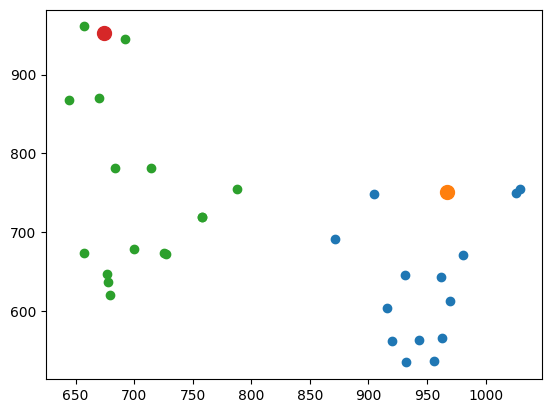


0: 384x640 2 persons, 70.2ms
Speed: 2.2ms preprocess, 70.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
1/1 [==============================] - 1s 943ms/step


KeyboardInterrupt: 

In [44]:
main()

In [18]:
## save frame from video

vidcap = cv2.VideoCapture('Let/test.mp4')
while True:
    success, frame = vidcap.read()
    if success:
        cv2.imwrite('test_frame.jpg', frame)

    break
        

#### Create box on court to get player location

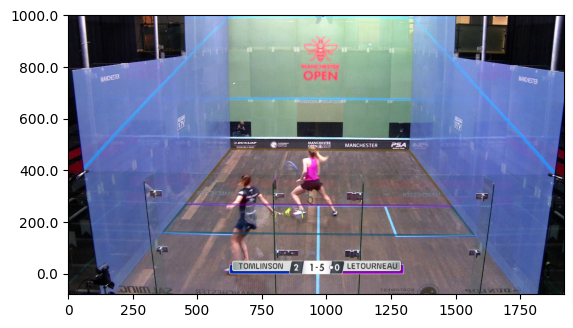

#### Extend box to cover whole court

#### This works where the back corners of the court are when you cannot see them

#### Draw final box

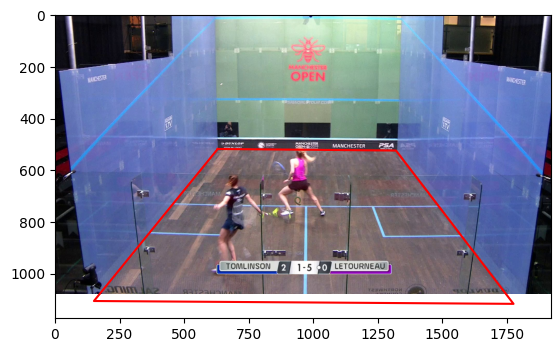

In [19]:
class Court:

    def __init__(self, front_wall, box, front_box):
        '''
        All coordinates must be a tuple 
        where the list in index 0 are the X coordinates
        and index 1 are the Y coordinates

        all coordinate systems go top left, top right, bottom right, bottom left
        unless stated otherwise
        '''
        self.front_wallX, self.front_wallY = front_wall
        self.boxX, self.boxY = box
        self.front_boxX, self.front_boxY = front_box

        self.front_short_true = 5440
        self.box_true = 1600
        self.remainding_distance_true = 2610

        back_pointsL, back_pointsR = self.calc_back()

        self.final_cornersX = [self.front_wallX[0], self.front_wallX[1], back_pointsR[0], back_pointsL[0], self.front_wallX[0]]
        self.final_cornersY = [self.front_wallY[0], self.front_wallY[1], back_pointsR[1], back_pointsL[1], self.front_boxY[0]]

        # top left, top right, bottom left, bottom right
        self.final_corners = np.array([[self.final_cornersX[0], self.final_cornersY[0]],
                                       [self.final_cornersX[1], self.final_cornersY[1]],
                                        [self.final_cornersX[3], self.final_cornersY[3]],
                                         [self.final_cornersX[2], self.final_cornersY[2]]])

    def distance_ratio(self, dist, scale):
        return dist/scale
    
    def find_final_point(self, starting_point, further_point, distance):
        x1, y1 = starting_point
        x2, y2 = further_point
    
        # Calculate the distance between the two points
        distance_between_points = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
        # Calculate the coordinates of the final point
        x = x2 + (distance * (x2 - x1)) / distance_between_points
        y = y2 + (distance * (y2 - y1)) / distance_between_points
    
        return x, y
    
    def calc_distance(self, X, Y):
        right = ((X[0] - X[3])**2 + (Y[0] - Y[3])**2)**0.5
        left = ((X[1] - X[2])**2 + (Y[1] - Y[2])**2)**0.5
        return left, right 

    def calc_ratios(self, cornersX, cornersY, true_distance):

        distance_left, distance_right = self.calc_distance(cornersX, cornersY)

        ratio_left = self.distance_ratio(distance_left, true_distance)
        ratio_right = self.distance_ratio(distance_right, true_distance)

        return ratio_left, ratio_right

    def calc_back(self):

        # calculate the scale factors for different parts of the court
        front_short_ratioL, front_short_ratioR = self.calc_ratios(self.front_wallX, self.front_wallY, self.front_short_true)
        box_ratioL, box_ratioR = self.calc_ratios(self.boxX, self.boxY, self.box_true)

        # calculate scale factor for the final distance
        scale_factor_left = box_ratioL + (box_ratioL - front_short_ratioL)
        scale_factor_right = box_ratioR + (box_ratioR - front_short_ratioR)

        # calculate the final distance left
        remainding_distance_left = self.remainding_distance_true*scale_factor_left
        remainding_distance_right = self.remainding_distance_true*scale_factor_right
        
        # find the positions of the back points
        back_p_left = self.find_final_point((self.front_boxX[0], self.front_boxY[0]), (self.front_boxX[3], self.front_boxY[3]), remainding_distance_left)
        back_p_right = self.find_final_point((self.front_boxX[1], self.front_boxY[1]), (self.front_boxX[2], self.front_boxY[2]), remainding_distance_right)

        return back_p_left, back_p_right

In [6]:
cornersX = [630, 1320, 1485, 457, 630]
cornersY = [517, 523, 738, 730, 517]

serv_boxX = [457, 1485, 1573, 367, 457]
serv_boxY = [730, 738, 853, 840, 730]

serv_frontX = [630, 1320, 1573, 367, 630]
serv_frontY = [517, 523, 853, 840, 517]

court = Court((cornersX, cornersY), (serv_boxX, serv_boxY), (serv_frontX, serv_frontY))

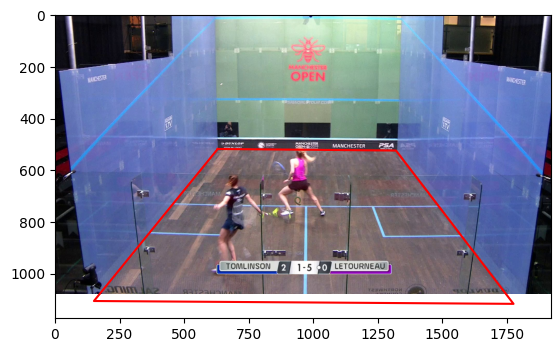

In [7]:
img = np.asarray(Image.open('test_frame.jpg'))
plt.imshow(img)

plt.plot(court.final_cornersX, court.final_cornersY, c='red')

plt.show()

In [275]:
court.final_corners

array([[        630,         517],
       [       1320,         523],
       [      150.8,      1105.5],
       [       1775,      1116.5]])

### Work out feet position in relation to floor

In [54]:
def create_mask(court):
    true_court_width = 762
    true_court_length = 975
    # get x, y of feet position
    true_court_corners = np.array([[0, 0],
                                   [true_court_width, 0],
                                   [0, true_court_length],
                                   [true_court_width, true_court_length]])

    M, mask = cv2.findHomography(court.final_corners, true_court_corners)
    return M

    # find distance from feet to the corners

In [55]:
def use_mask(x, y, court):
    
    M = create_mask(court)
    denom = M[2,0] *x + M[2,1] * y + M[2,2]
    xPrime = (M[0,0] *x + M[0,1] * y + M[0,2]) / denom
    yPrime = (M[1,0] *x + M[1,1] * y + M[1,2]) / denom
    
    return int(xPrime), int(yPrime)

In [ ]:
squash_court = ([0, 762, 762, 0, 0], [0, 0, 975, 975, 0])
short_line = ([0, 762], [544, 544])
half_court_line = ([762//2, 762//2], [544, 975])
box1 = ([0, 160, 160, 0], [544, 544, 544+160, 544+160])
box2 = ([762, 762-160, 762-160, 762], [544, 544, 544+160, 544+160])

plt.figure(figsize=(7.62/2, 9.75/2))
plt.plot(*squash_court, c='red')
plt.plot(*short_line, c='red')
plt.plot(*half_court_line, c='red')
plt.plot(*box1, c='red')
plt.plot(*box2, c='red')
plt.scatter(*use_mask(*feetpositions[0][0], court))
plt.scatter(*use_mask(*feetpositions[0][1], court))
plt.show()

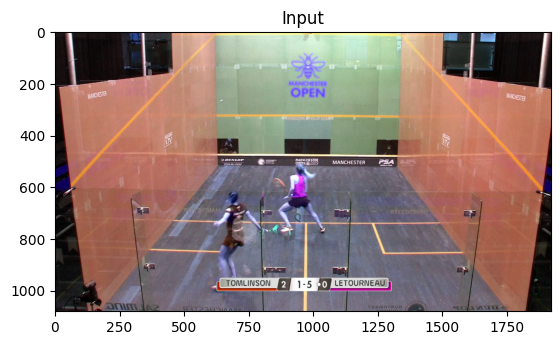

In [14]:
img = cv2.imread('test_frame.jpg')

rows,cols,ch = img.shape
pts1 = np.float32(court.final_corners)
true_court_width = 762
true_court_length = 975
# get x, y of feet position
pts2 = np.float32([[0, 0],
               [true_court_width, 0],
               [0, true_court_length],
               [true_court_width, true_court_length]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(true_court_width,true_court_length))
plt.imshow(img)
plt.title('Input')
plt.show()



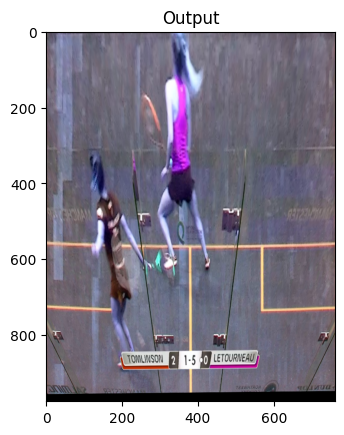

In [15]:
plt.imshow(dst)
plt.title('Output')
plt.show()

In [1]:
# Click event callback function
def click_event(event, x, y, flags, param):
    global xs, ys
    if event == cv2.EVENT_LBUTTONDOWN:
        xs.append(x)
        ys.append(y)
        if len(xs) >= max_points:
            cv2.destroyAllWindows()

def get_clicked_points(img, window_name='image'):

    # Display the image
    cv2.imshow(window_name, img)

    # Set mouse callback function for window
    cv2.setMouseCallback(window_name, click_event)

    while len(xs) < max_points:
        # Exit the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    return xs, ys

def test_court():
    # path to an image of a squash court
    img_path = 'Test/squash_court.jpg'
    img = cv2.imread(img_path)
    x, y = get_clicked_points(img)

    cornersX = [x[0], x[1], x[3], x[2], x[0]]
    cornersY = [y[0], y[1], y[3], y[2], y[0]]
    
    serv_boxX = [x[2], x[3], x[5], x[4], x[2]]
    serv_boxY = [y[2], y[3], y[5], y[4], y[2]]
    
    serv_frontX = [x[0], x[1], x[5], x[4], x[0]]
    serv_frontY = [y[0], y[1], y[5], y[4], y[0]]
    
    court = Court((cornersX, cornersY), (serv_boxX, serv_boxY), (serv_frontX, serv_frontY))

    img = np.asarray(Image.open(img_path))
    plt.imshow(img)
    
    plt.plot(court.final_cornersX, court.final_cornersY, c='red')
    
    plt.show()


        

In [2]:
xs = []
ys = []
max_points = 6
test_court()

NameError: name 'cv2' is not defined

(-2, 0)
(761, -8)
(3, 575)
(760, 564)
(1, 741)
(760, 736)
(383, 570)


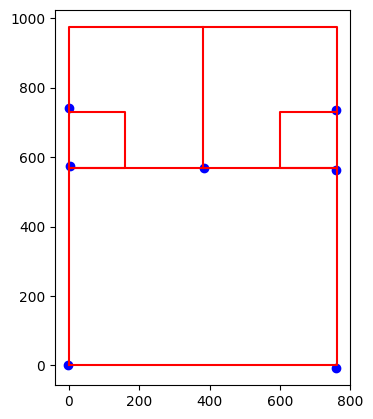

In [62]:
def test_feetpos():
    img_path = 'Test/squash_court.jpg'
    img = cv2.imread(img_path)

    
    circle_centers = [(242, 243), (566, 241), (144, 349), (661, 345), (85, 409), (717, 406), (404, 347)]
    
    # Draw circles on the image
    for i, center in enumerate(circle_centers):
        cv2.circle(img, center, 5, (0,0,255), -1)

    # Display the image
    #cv2.imshow('image', img)

    x, y = get_clicked_points(img, 'squash')

    cornersX = [x[0], x[1], x[3], x[2], x[0]]
    cornersY = [y[0], y[1], y[3], y[2], y[0]]
    
    serv_boxX = [x[2], x[3], x[5], x[4], x[2]]
    serv_boxY = [y[2], y[3], y[5], y[4], y[2]]
    
    serv_frontX = [x[0], x[1], x[5], x[4], x[0]]
    serv_frontY = [y[0], y[1], y[5], y[4], y[0]]
    
    court = Court((cornersX, cornersY), (serv_boxX, serv_boxY), (serv_frontX, serv_frontY))

    squash_court = ([0, 762, 762, 0, 0], [0, 0, 975, 975, 0])
    short_line = ([0, 762], [570, 570])
    half_court_line = ([762//2, 762//2], [570, 975])
    box1 = ([0, 160, 160, 0], [570, 570, 570+160, 570+160])
    box2 = ([762, 762-160, 762-160, 762], [570, 570, 570+160, 570+160])
    
    plt.figure(figsize=(7.62/2, 9.75/2))
    plt.plot(*squash_court, c='red')
    plt.plot(*short_line, c='red')
    plt.plot(*half_court_line, c='red')
    plt.plot(*box1, c='red')
    plt.plot(*box2, c='red')
    for pos in circle_centers:
        new_pos = use_mask(*pos, court)
        print(new_pos)
        plt.scatter(*new_pos, c='blue')
    plt.show()

xs = []
ys = []
test_feetpos()

In [55]:
Clicked at: (242, 243)
Clicked at: (566, 241)
Clicked at: (143, 348)
Clicked at: (663, 346)
Clicked at: (87, 410)
Clicked at: (718, 406)
Clicked at: (404, 347)

In [32]:
cv2.destroyAllWindows()